Chicago has a lot of cool things going on, but from a data science perspective one of the most exciting is the awesome [Chicago Data Portal](https://data.cityofchicago.org/). Hundreds of datasets are available to download, covering all aspects of life in the city, from where potholes were patched in the past week to the temperature of the lake. Prompted by a question on the [Chicago Ideas Week](http://www.thinkchicago.net/) application, I want to use some of this data to address the following question: how can we use civic data to inform policy decisions at the city level, and in particular, can we use data to intelligently craft policies that benefit the most economically depressed regions of the city?

This write-up is a proof-of-concept, not a precise analysis; consider it an exploration of how civic data could be used to guide policy decisions, not an actual study with concrete policy recommendations. In keeping with the open data ethos of the Chicago Data Portal, all the code used in this analysis is available [here](/notebooks/2015-09-13-chicago-business-licenses.ipynb) as an IPython notebook.

We'll start by loading some standard Python tools and the datasets.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans

For this project we'll use two datasets from the Chicago Data Portal: one describing the active business licenses in the city, and one describing a set of socio-economic indicators for each [Community Area](https://en.wikipedia.org/wiki/Community_areas_in_Chicago) in Chicago as measured by the 2010 Census.

In [28]:
licenses = pd.read_csv('licenses.csv', skipinitialspace=True, usecols=[0,1,4,5,6,7,8,9,10,11,12,13,14,24])

census = pd.read_csv('census.csv', skipinitialspace=True).dropna()

/home/jhenri/anaconda3/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


One of the central challenges in making public policy decisions is measuring what works. Often the time scales at which the policies produce results are much too long to inform subsequent decisions. In this situation, where deliberately measuring the effect of some event is infeasible, a popular strategy is to look for [natural experiments](https://en.wikipedia.org/wiki/Natural_experiment), where coincidence has provided two groups with similar characteristics but different outcomes. By looking at which traits are shared and which traits differ between the two groups, one can gain some information about the correlation between certain group characteristics and outcomes.

Since the point of this analysis is to explore data-informed policy decisions that could benefit the most economically depressed regions of the city, our first step is to somehow group these regions in a way that lets us look for natural experiments. In this case I'm going to use a machine learning algorithm called [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) to group Community Areas based on five socio-economic indicators included in the census data.

In [132]:
# use socio-economic indicators (but not per capita income) to cluster CAs 
fit_stats = census.columns[2:7]
cluster = KMeans(4, random_state=0).fit_predict(census[fit_stats])

# add cluster column to census df
census['cluster'] = cluster

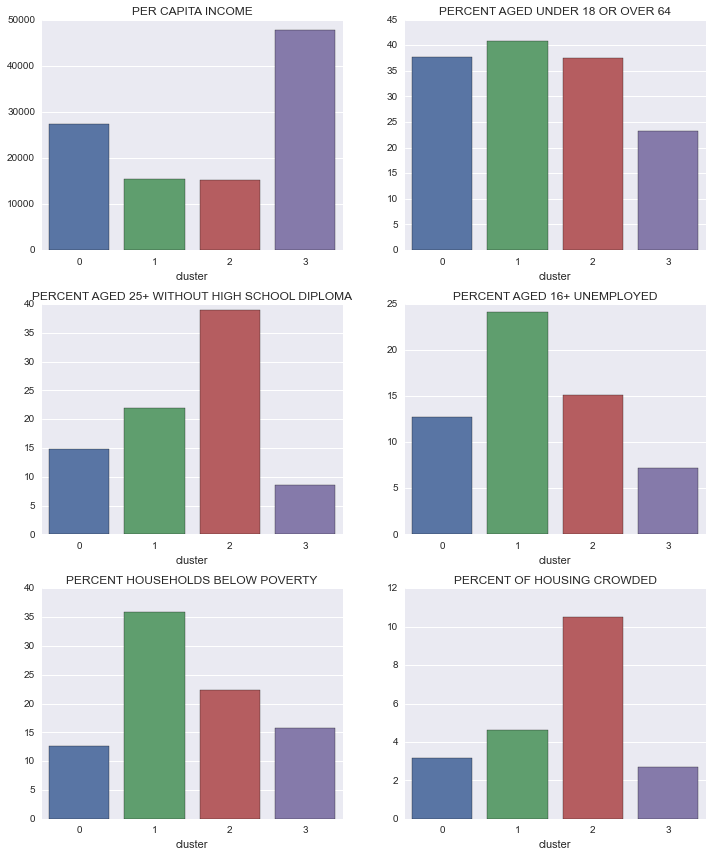

In [133]:
# plot the average statistics for each cluster
fig, axes = plt.subplots(3,2, figsize=(10,12))

axes_flat = [ax for ax_row in axes for ax in ax_row]
cols = census.groupby('cluster').mean().columns[1:7][::-1]

for ax, col in zip(axes_flat, cols):
    sns.barplot(x='cluster', y=col, data=census.groupby('cluster').mean().reset_index(), ax=ax);
    ax.set_ylabel('')
    ax.set_title(col)
    
fig.tight_layout()

It looks like clusters 1 and 2 are good candidates for our natural experiment groups: both have approximately the same per-capita income, but cluster 1 has about 1.5 times as many households living below the poverty line. Looking at the other indicators, it seems that unemployment could be a large factor driving this difference; unemployment among adults aged 16+ is nearly ten percentage points higher in cluster 1 than in cluster 2.

If the lack of employment opportunities is a driving factor in the incidence of poverty, then looking at the employment opportunities in cluster 2 (which is economically similar, but has lower unemployment) could provide insights into what policies might be effective in reducing unemployment in cluster 1. For example, if we find certain classes of businesses are over-represented in cluster 2 relative to cluster 1, then we could recommend policies to encourage the development of those types of businesses in cluster 1.

In this analysis we'll use data about active business licenses as a proxy for local employment opportunities; if this were an internal city analysis presumably they could use tax data to get much better information. Just to keep things tidy, we'll only consider categories that have at least 20 active licenses in the city.

In [29]:
# set the thresholds for license type to be included in the analysis
MIN_LICENSE = 20

# count how many of each type of license in the city
license_counts = licenses.groupby('LICENSE DESCRIPTION').count().sort('ID')

# generate list of types with more than threshold number of occurences
trim_license_list = license_counts.loc[license_counts['ID']>MIN_LICENSE].index

# filter out those with less than threshold number of occurences
licenses = licenses.loc[licenses['LICENSE DESCRIPTION'].isin(trim_license_list)]

We're almost ready to combine the business license data with the census data, but there's one small hiccup: the license data is listed by the Ward the business operates in, while the census data is specified by Community Area. Community Areas and Wards generally don't line up -- one Ward can be in multiple Community Areas, while each Community Area contains pieces of multiple Wards.

To get around this, we have to make an ad-hoc mapping from Ward-level data to Community Area data (we're mapping the Ward data onto Community Area data instead of vice versa because the Community Areas better correspond to actual neighborhoods). The easiest way I can think of to do this is to take a population-weighted average: for each Community Area we calculate approximate business license statistics by averaging the statistics from each Ward the Area encompases, weighted by population. Fortunately someone has already tabulated this population [information](http://robparal.blogspot.com/2013/07/chicago-ward-and-community-area.html).

In [144]:
ca_to_ward = pd.read_csv('CAtoWARD.csv', skipinitialspace=True)

# standardize column names
ca_to_ward.columns = ['CA','Ward','POP2010']

# calculate the total population of each CA, for later use
ca_pops = ca_to_ward.groupby('CA').sum()['POP2010']

# make a mapping from CA number to name, for later use
ca_names = census.set_index('Community Area Number')['COMMUNITY AREA NAME']

# give the df a multi-index
ca_to_ward = ca_to_ward.groupby(['CA','Ward']).sum()

print(ca_to_ward.head(6))

         POP2010
CA Ward         
1  40       1704
   49      53287
   50          0
2  40      15939
   49       2608
   50      53395


In [226]:
# count total licenses by type, for each ward
licenses_by_ward = licenses.groupby(['WARD','LICENSE DESCRIPTION']).count()
licenses_by_ward.index.names = ['Ward', 'LICENSE DESCRIPTION']

# rearrange the data so that each type of license gets its own column, indexed by Ward #
licenses_by_ward = licenses_by_ward.reset_index().pivot(index='Ward', columns='LICENSE DESCRIPTION', values='ID').fillna(0)

# join the ward-ca population df with the license stats df
licenses_by_ca = ca_to_ward.join(licenses_by_ward)

# multiply each crime stat by ward population, sum over wards in CA, then divide by CA population
licenses_by_ca = licenses_by_ca.apply(mult_by_pop, axis=1).sum(level=0).div(ca_pops, axis=0)

# normalize by CA population, then multiply by 10000 so numbers are per 10k residents
norm_licenses = licenses_by_ca.div(ca_pops, axis=0)*10000

# define the zscore function
zscore = lambda x: (x - x.mean()) / x.std()

# convert 'per 10k residents' entries to zscores
norm_licenses = norm_licenses.apply(zscore)

At this point we have an approximate number of active business licenses (per 10,000 residents), broken down by type of license, for each Community Area in Chicago. Next we'll compare the prevalence of each type of business license between clusters 1 and 2.

In [227]:
census_1 = census.loc[census['cluster']==1].set_index('Community Area Number')
census_2 = census.loc[census['cluster']==2].set_index('Community Area Number')

licenses_1 = norm_licenses.ix[census_1.index]
licenses_2 = norm_licenses.ix[census_2.index]

# to avoid duplicat column names
census_cols = census_1.columns
license_cols = licenses_1.columns
cols_non_overlap = census_1.columns.difference(licenses_1.columns)

# combine census and normalized license data
hmap_data = pd.concat([licenses_1, census_1[cols_non_overlap]], axis=1)

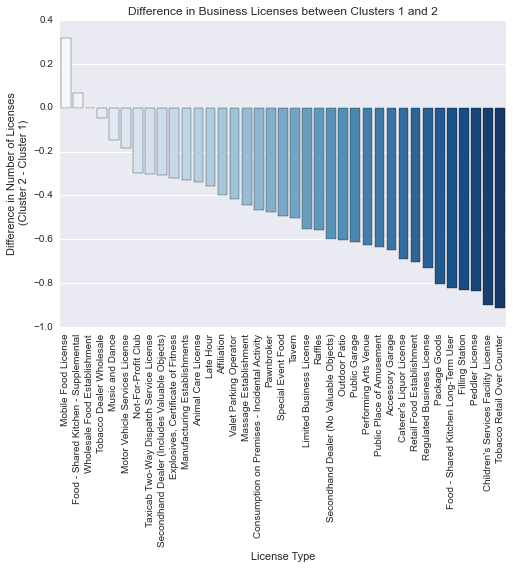

In [230]:
# plot the difference in number of licenses between cluster 1 and cluster 2
diffs = pd.DataFrame((licenses_2.mean() - licenses_1.mean())).reset_index()
diffs.columns = ['License Type', 'Licenses']

pal = sns.color_palette("Blues", n_colors=len(diffs))
sns.barplot(x='License Type', y='Licenses', data=diffs.sort('Licenses', ascending=False), palette=pal)
plt.title('Difference in Business Licenses between Clusters 1 and 2')
plt.ylabel('Difference in Number of Licenses\n (Cluster 2 - Cluster 1)')
plt.xticks(rotation='vertical');

Contrary to our original hypothesis, it appears that cluster 1 has more active business licenses than cluster 2 for almost all license categories. Cluster 1 has significantly higher unemployment, so it seems that the number of businesses present in a Community Area is a bad proxy for the availability of work. 

There are a number of things that could improve this analysis:

- Better data. Here we're using data that is fairly broad, both geographically in the case of the census data, and categorically in the case of the business license data. More precise data could uncover more subtle trends.

- A better question. I started this analysis with the data, and looked for trends that could contribute to policy-making decisions. A much more fruitful approach would be to collaborate with a subject matter expert (i.e. a social scientist, urban planner, community organizer, etc.) and use his/her expertise to direct the data-based analysis.

While this particular analysis didn't uncover any instructive trends it's easy to see how a similar project with better data could provide more actionable results. An internal analysis by a city department, with access to tax data, school records, and more detailed socio-economic indicators could make far more progress, and likely provide real insight into effective policies.

Finally, this is very simplistic analysis of an enormously complex issue. The main point is that the rapidly accumulating mountians of data about life in Chicago provide enormous opportunities for rigorous, quantitative policy analysis.